# Binary Classification Model for Bird Flu Outbreak Prediction - Optimizing

Why Didn't GridSearchCV Improve the Results?
Several potential reasons could explain why GridSearchCV failed to improve the model:

Already Optimal Parameters

If the initial RandomForestClassifier was well-configured (n_estimators=100 is reasonable), tuning might not significantly improve performance.
SMOTE Introduced Noisy Samples

While SMOTE helps with class imbalance, it can generate synthetic samples that do not truly represent the real distribution, causing overfitting.
Feature Selection Limitation

The selected features (Temp, Precipitation, Palmer Index, etc.) may not provide enough signal to separate outbreak vs. non-outbreak cases.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Set style for better visualization
plt.style.use('seaborn-v0_8')

## Data Loading and Preprocessing

In [2]:
# Load datasets
weather_df = pd.read_csv('./Data/weather.csv')
flocks_df = pd.read_csv('./Data/hpai-flocks.csv')
wild_birds_df = pd.read_csv('./Data/hpai-wild-birds1.csv')
mammals_df = pd.read_csv('./Data/hpai-mammals.csv')

# Process dates for outbreak data
def process_dates(df):
    df['Outbreak Date'] = pd.to_datetime(df['Outbreak Date'])
    df['Month'] = df['Outbreak Date'].dt.month
    df['Year'] = df['Outbreak Date'].dt.year
    return df

flocks_df = process_dates(flocks_df)
wild_birds_df = process_dates(wild_birds_df)
mammals_df = process_dates(mammals_df)

## Feature Engineering

In [3]:
# Create monthly outbreak summaries
all_outbreaks = pd.concat([
    flocks_df[['State', 'County', 'Month', 'Year']].assign(dataset='flocks'),
    wild_birds_df[['State', 'County', 'Month', 'Year']].assign(dataset='wild_birds'),
    mammals_df[['State', 'County', 'Month', 'Year']].assign(dataset='mammals')
])

# Count outbreaks per county per month
outbreak_counts = all_outbreaks.groupby(['State', 'County', 'Month', 'Year']).size().reset_index(name='outbreak_count')

# Clean county names
outbreak_counts['County'] = outbreak_counts['County'].str.strip()
weather_df['County'] = weather_df['County'].str.strip()

# Create a cross join of weather data with months (1-12)
weather_monthly = pd.DataFrame({
    key: np.repeat(weather_df[key].values, 12) 
    for key in weather_df.columns
})
weather_monthly['Month'] = np.tile(np.arange(1, 13), len(weather_df))

## Data Merging and Preparation

In [4]:
# Merge weather data with outbreak counts
merged_data = pd.merge(
    weather_monthly,
    outbreak_counts,
    on=['State', 'County', 'Month'],
    how='left'
)

# Fill NaN values and create binary target
merged_data['outbreak_count'] = merged_data['outbreak_count'].fillna(0)
merged_data['has_outbreak'] = (merged_data['outbreak_count'] > 0).astype(int)

# Select features
features = ['Temp', 'Temp Anomaly (1901-2000 base period)', 
           'Precipitation', 'Prec Anomaly (1901-2000 base period)',
           'Z Palmer Index', 'Z Anomaly (1901-2000 base period)',
           'Month']

X = merged_data[features]
y = merged_data['has_outbreak']

## Model Training and Evaluation

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train binary classification model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = clf.predict(X_test_scaled)
y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

In [6]:
# Hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           scoring='f1',
                           verbose=2,
                           n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters and model
print('Best Parameters:', grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_tuned = best_model.predict(X_test_scaled)
print('Classification Report (Tuned Model):')
print(classification_report(y_test, y_pred_tuned))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6704
           1       0.56      0.46      0.51       867

    accuracy                           0.90      7571
   macro avg       0.75      0.71      0.72      7571
weighted avg       0.89      0.90      0.89      7571



## Model Performance Analysis

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6704
           1       0.56      0.47      0.51       867

    accuracy                           0.90      7571
   macro avg       0.74      0.71      0.72      7571
weighted avg       0.89      0.90      0.89      7571



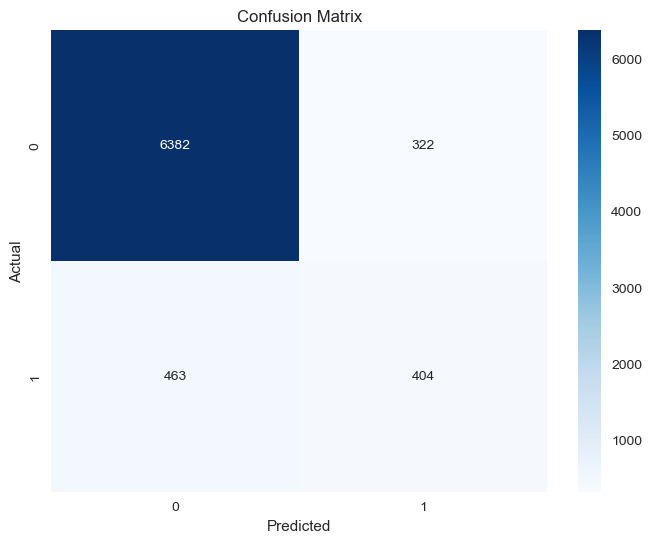

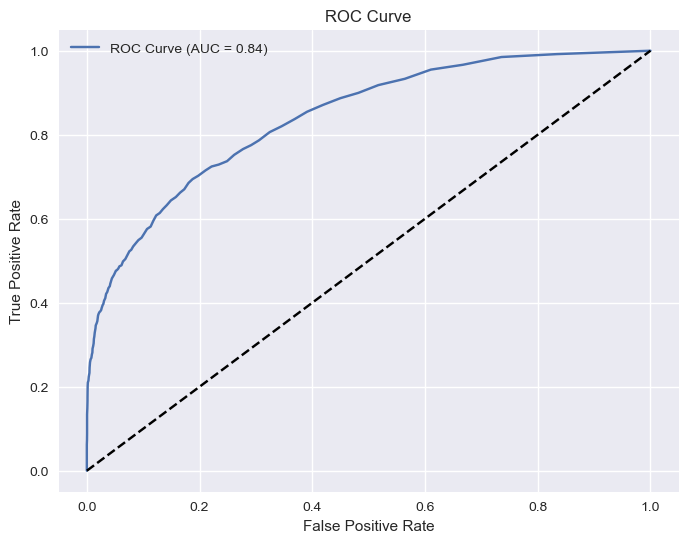

In [7]:
# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Feature Importance Analysis

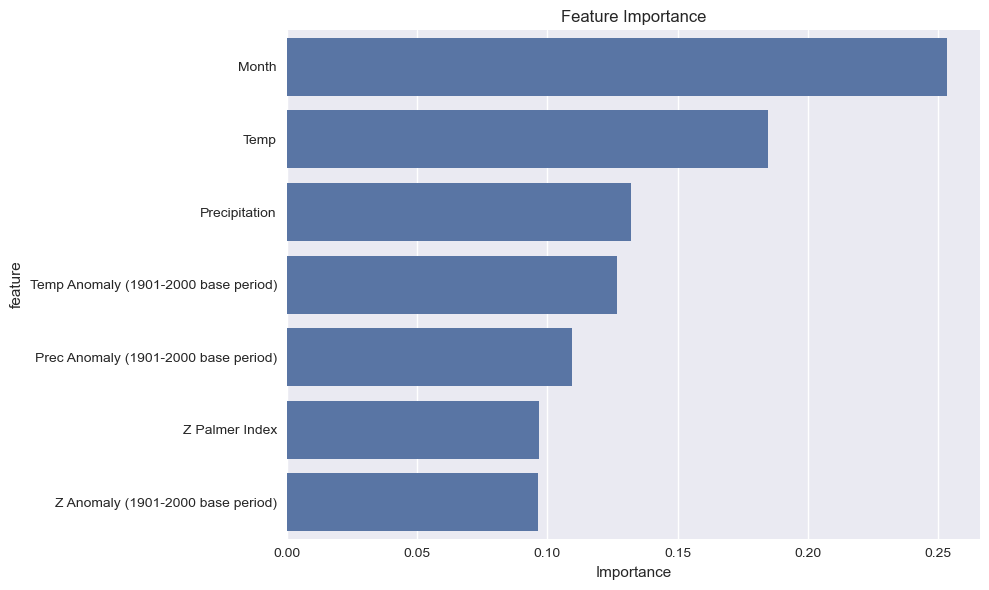

In [8]:
# Calculate and plot feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()